In [336]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import subplot
import pandas as pd
import random

from matplotlib.ticker import PercentFormatter
# Variables given in question

paths = 50000

S0 = 100
sigma = 0.2
r = 0.05
maturity = 1/12
K = 100

N_1 = 21
N_2 = 84

step_size_1 = maturity / N_1
step_size_2 = maturity / N_2

# Prof Tee Functions
def phi(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return -K * np.exp(-r * T) * norm.cdf(d2)


def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T / steps
    t = np.linspace(0, T, steps + 1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

# own functions from part 3
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [337]:
def hedging_error_calculation(hedging_count, step_size):
    # simulate wt and bsm path
    T, W_T = simulate_Brownian_Motion(paths, hedging_count, maturity)
    blackscholespath = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * W_T)

    error_array = 0
    
    for i in range(hedging_count):
        t_px_array = blackscholespath[:, i]
        tp1_px_array = blackscholespath[:, i+1]
        delta_t = maturity - T[i]
        
        prev_stock_pos = phi(t_px_array, K, r, sigma, delta_t) * t_px_array
        prev_bond_pos = psi_Bt(t_px_array, K, r, sigma, delta_t) * np.exp(r * step_size)

        curr_stock_pos = phi(t_px_array, K, r, sigma, delta_t) * tp1_px_array
        curr_bond_pos = psi_Bt(t_px_array, K, r, sigma, delta_t)

        curr_hedge = curr_stock_pos - curr_bond_pos
        prev_hedge = prev_stock_pos - prev_bond_pos
        tplus1_hedge = curr_hedge - prev_hedge
        error_array += tplus1_hedge    

    pnl = error_array + BlackScholesCall(S0, K, r, sigma, maturity) - np.maximum(blackscholespath[:,-1]-K,0)
    
    return pnl

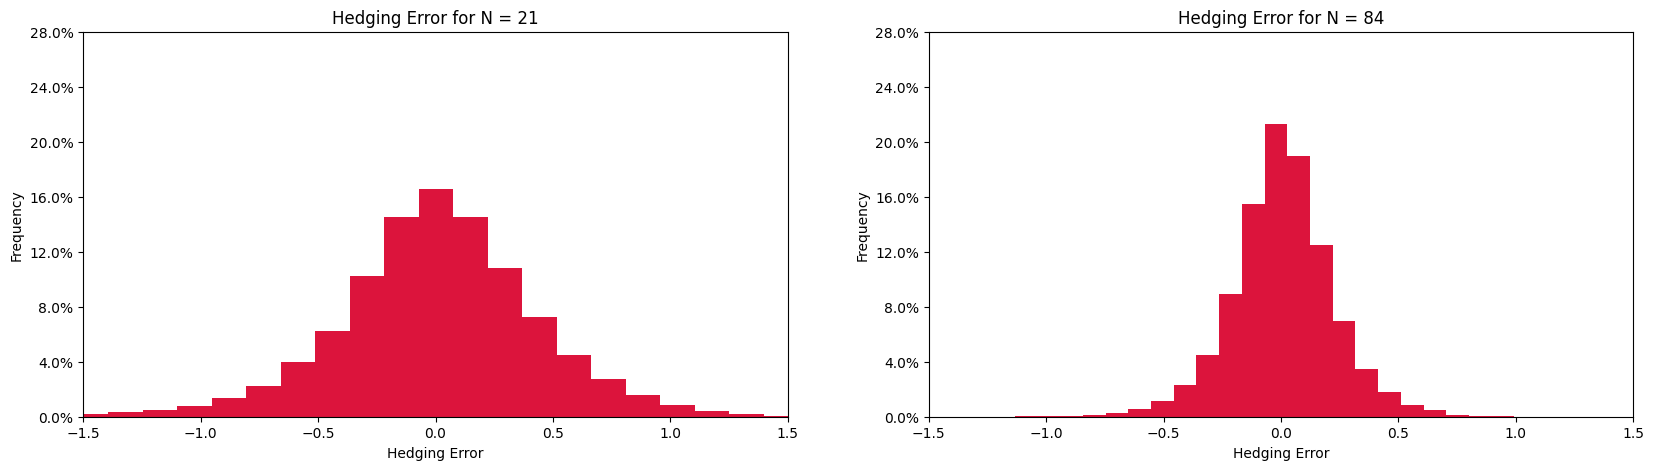

In [338]:
np.random.seed(1)

pnl_21 = hedging_error_calculation(N_1, step_size_1)

pnl_84 = hedging_error_calculation(N_2, step_size_2)

hedge_count = [pnl_21, pnl_84]
N = [21, 84]

plt.figure(figsize=(20, 5))

for i in range(0, len(hedge_count)):

    subplot(1, 2, i + 1)
    plt.hist(hedge_count[i], weights = np.ones(len(hedge_count[i])) / len(hedge_count[i]), bins = 30, color = 'crimson')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title(f'Hedging Error for N = {N[i]}')
    plt.xlabel('Hedging Error')
    plt.ylabel('Frequency')
    plt.xlim(-1.5, 1.5)
    plt.yticks(np.arange(0,0.28,0.04))
plt.show()

In [339]:
print('Hedging 21 Times:')
print(f'Mean error: {round(pnl_21.mean(),5)}\nStandard Deviation: {round(pnl_21.std(), 2)}\nStd of PnL as a % of Option Premium: {round(100 * pnl_21.std() / BlackScholesCall(S0, K, r, sigma, maturity), 1)}%')
print()
print('Hedging 84 Times:')
print(f'Mean error: {round(pnl_84.mean(),5)}\nStandard Deviation: {round(pnl_84.std(), 2)}\nStd of PnL as a % of Option Premium: {round(100 * pnl_84.std() / BlackScholesCall(S0, K, r, sigma, maturity), 1)}%')

Hedging 21 Times:
Mean error: 0.00744
Standard Deviation: 0.42
Std of PnL as a % of Option Premium: 16.9%

Hedging 84 Times:
Mean error: 0.00577
Standard Deviation: 0.22
Std of PnL as a % of Option Premium: 8.7%
